## Sprint 2: Clusterización y Series de Tiempo (ICFES)

### - Andres Fernando Nieto Rodriguez - 2220231083
### - David Santiago Manchola Serna - 2220221093
### - Oscar Daniel Casallas Lozano - 2220221011

Objetivo :
- Aplicar 3 técnicas de clusterización: K-Means (particional), DBSCAN (densidad) y un modelo jerárquico (Agglomerative).
- Aplicar análisis de series de tiempo con un modelo estadístico (ARIMA) y un modelo RNN (LSTM o GRU).
- Evaluar con métricas simples (MAE/RMSE) y ajustar de forma básica.

Nota: Reusamos los datasets limpios del Sprint 1 presentes en este directorio (CSV con sufijo `_LIMPIO`).


### Setup e importación

Prepara el entorno del notebook:
- Configura warnings y estilos de gráficos.
- Añade la carpeta `src/` al `sys.path` para importar el paquete `icfes_analytics` que contiene funciones reutilizables.
- Importa librerías de análisis (pandas, numpy, matplotlib, seaborn) y utilidades del paquete para clustering y series de tiempo.
- Descubre y carga los CSV limpios del Sprint 1 (Saber 11 y Saber Pro) y muestra una vista rápida de columnas.

In [2]:
# 1) Setup y carga de datos (Sprint 1 -> datasets limpios) + bootstrap de módulos src/
import warnings, sys
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Añadir src/ al sys.path para importar icfes_analytics
SRC = Path.cwd() / "src"
if SRC.exists() and str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from icfes_analytics import (
    apply_btc_style,
    parse_periodo_flexible, aggregate_series,
    fit_arima_small_grid, plot_arima_forecast,
    forecast_one_step_numpy,
)
from icfes_analytics.clustering import (
    seleccionar_cols_puntaje, run_six_clustering_plots
)

# Clustering
from sklearn.preprocessing import StandardScaler

# Descubrir y cargar CSVs limpios
BASE = Path.cwd()
pat_s11 = sorted(BASE.glob("Dataset1*LIMPIO.csv"))
pat_spro = sorted(BASE.glob("Dataset2*LIMPIO.csv"))

if not pat_s11 and not pat_spro:
    raise FileNotFoundError("No se encontraron archivos LIMPIO.csv del Sprint 1 en el directorio actual.")

saber11 = pd.read_csv(pat_s11[-1]) if pat_s11 else None
saberpro = pd.read_csv(pat_spro[-1]) if pat_spro else None

print("Archivos detectados:")
if saber11 is not None:
    print(" - Saber11:", pat_s11[-1].name, saber11.shape)
if saberpro is not None:
    print(" - SaberPro:", pat_spro[-1].name, saberpro.shape)

# Vista rápida de columnas clave
for name, df in [("saber11", saber11), ("saberpro", saberpro)]:
    if df is None:
        continue
    cols = df.columns.tolist()
    print(f"\n[{name}] columnas (primeras 20):")
    print(cols[:20])

Archivos detectados:
 - Saber11: Dataset1–Saber11(2020-2)_LIMPIO.csv (504872, 77)
 - SaberPro: Dataset2–SaberPro(2021–2024)_LIMPIO.csv (281601, 88)

[saber11] columnas (primeras 20):
['estu_tipodocumento', 'estu_nacionalidad', 'estu_genero', 'periodo', 'estu_estudiante', 'estu_pais_reside', 'estu_tieneetnia', 'estu_depto_reside', 'estu_cod_reside_depto', 'estu_mcpio_reside', 'estu_cod_reside_mcpio', 'fami_estratovivienda', 'fami_personashogar', 'fami_cuartoshogar', 'fami_educacionpadre', 'fami_educacionmadre', 'fami_trabajolaborpadre', 'fami_trabajolabormadre', 'fami_tieneinternet', 'fami_tieneserviciotv']

[saberpro] columnas (primeras 20):
['periodo', 'estu_estudiante', 'estu_tipodocumento', 'estu_nacionalidad', 'estu_actividadrefuerzoareas', 'estu_actividadrefuerzogeneric', 'estu_agregado', 'estu_cod_depto_presentacion', 'estu_cod_mcpio_presentacion', 'estu_cursodocentesies', 'estu_cursoiesapoyoexterno', 'estu_cursoiesexterna', 'estu_depto_presentacion', 'estu_discapacidad', 'estu_e

### Preparación de features

Aquí se elige el dataset principal (priorizando Saber Pro). Luego:
- Se detectan columnas de puntajes (contienen "punt").
- Se filtran valores numéricos y se eliminan nulos.
- Se estandarizan las features con `StandardScaler` para usarlas en los algoritmos de clustering.

In [3]:
# 2) Preparación de features para clusterización (mínimo y robusto)

# Preferimos trabajar con Saber Pro para la parte de series de tiempo (2021–2024).

# Si no está disponible, usamos Saber 11 como respaldo.

def _elige_principal(saberpro, saber11):
    if saberpro is not None:
        return "saberpro", saberpro
    if saber11 is not None:
        return "saber11", saber11
    raise RuntimeError("No hay datasets disponibles para preparar features.")

principal_name, principal_df = _elige_principal(saberpro, saber11)

feat_cols = seleccionar_cols_puntaje(principal_df)
if not feat_cols:
    raise RuntimeError("No se detectaron columnas de puntajes ('punt') en el dataset principal.")

X = principal_df[feat_cols].select_dtypes(include=[np.number]).copy()
X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dataset principal: {principal_name} | Observaciones usadas: {X.shape[0]} | Features: {feat_cols}")

Dataset principal: saberpro | Observaciones usadas: 281601 | Features: ['punt_global', 'mod_lectura_critica_punt', 'mod_razona_cuantitat_punt', 'mod_ingles_punt', 'mod_competen_ciudada_punt', 'mod_comuni_escrita_punt']


### Clusterización (6 métodos)

Se ejecutan seis técnicas sobre una proyección PCA 2D para visualizar de forma consistente:
- Particional: MiniBatchKMeans.
- Jerárquico: Ward y Average (con conectividad k-NN y reducción opcional por centroides).
- Densidad: DBSCAN.
- Basado en árbol: BIRCH.
- Mixtos: GaussianMixture.
La figura 2x3 comparte ejes, minimiza espacios y muestra conteos por cluster.

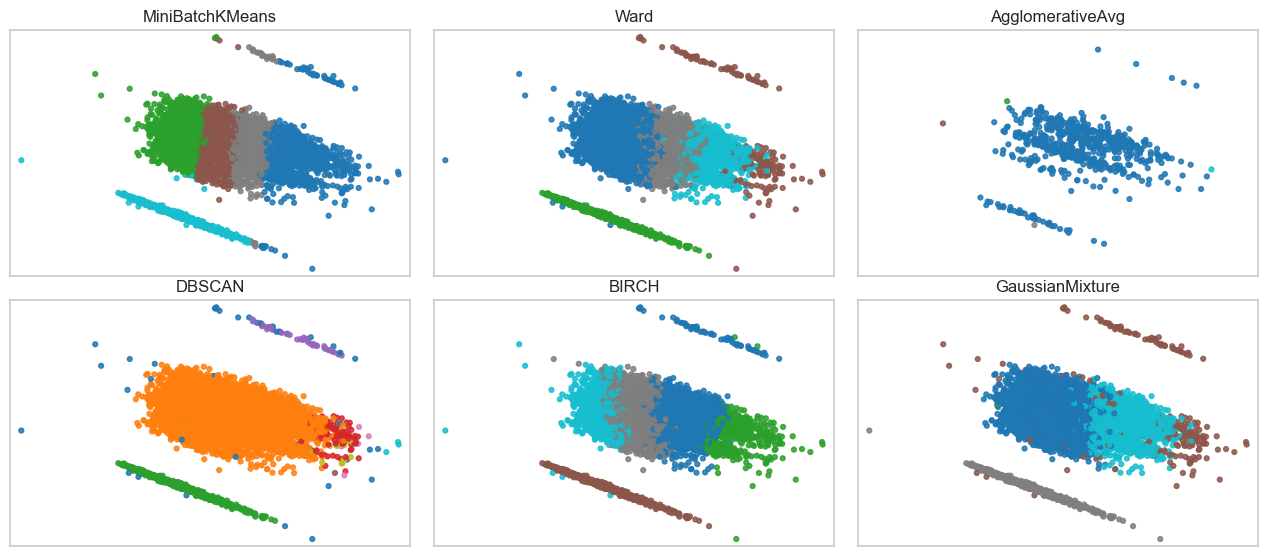

MiniBatchKMeans -> conteos: Counter({np.int32(2): 79985, np.int32(3): 79360, np.int32(1): 55398, np.int32(0): 47892, np.int32(4): 18966})
Ward -> conteos: Counter({np.int64(0): 4548, np.int64(3): 2891, np.int64(4): 1700, np.int64(1): 662, np.int64(2): 199})
AgglomerativeAvg -> conteos: Counter({np.int64(0): 596, np.int64(4): 1, np.int64(3): 1, np.int64(2): 1, np.int64(1): 1})
DBSCAN -> conteos: Counter({np.int64(0): 9110, np.int64(1): 659, np.int64(2): 107, np.int64(-1): 48, np.int64(3): 42, np.int64(7): 11, np.int64(6): 8, np.int64(4): 6, np.int64(5): 6, np.int64(8): 3})
BIRCH -> conteos: Counter({np.int64(0): 3791, np.int64(3): 3715, np.int64(4): 1211, np.int64(2): 662, np.int64(1): 621})
GaussianMixture -> conteos: Counter({np.int64(0): 5783, np.int64(4): 3224, np.int64(3): 663, np.int64(2): 326, np.int64(1): 4})
Clustering completado (6 métodos).


In [4]:
# 3) Clusterización (6 métodos y 6 gráficos) — usando el módulo icfes_analytics.clustering

import numpy as np
RANDOM_STATE = 42
n_clusters = 5            # ajusta si lo deseas
max_sample = 10_000       # submuestreo para métodos costosos

resumen = run_six_clustering_plots(X_scaled, n_clusters=n_clusters, random_state=RANDOM_STATE, max_sample=max_sample)
for nombre, conteos in resumen.items():
    print(f"{nombre} -> conteos:", conteos)
print('Clustering completado (6 métodos).')

## Series de tiempo (estilo BTC)

#### Serie agregada 

Convierte el campo `periodo` a fechas usando un parser flexible (YYYY, YYYYQ, YYYYMM) y agrega el `punt_global` promedio por periodo. Aplica el estilo de gráficos del ejemplo BTC y grafica la serie resultante.

Serie agregada (flexible) - puntos: 4


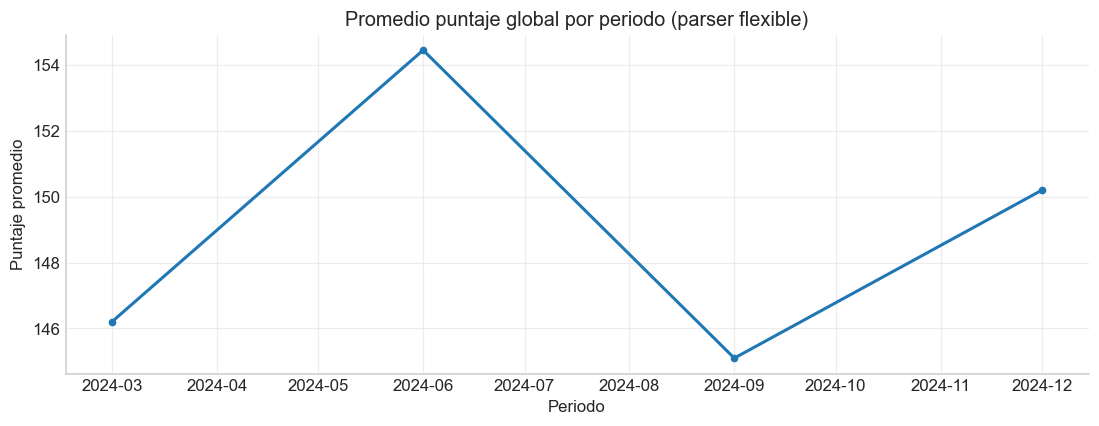

In [5]:
# 4) Serie agregada con parser flexible y estilo BTC (módulos)
from icfes_analytics import apply_btc_style, parse_periodo_flexible, aggregate_series

apply_btc_style()

serie_df = saberpro if saberpro is not None else saber11
agg2 = aggregate_series(serie_df, period_col='periodo', value_col='punt_global', parser=parse_periodo_flexible)
print('Serie agregada (flexible) - puntos:', len(agg2))

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(agg2.index, agg2.values, color='#1f77b4', lw=2, marker='o', ms=4)
ax.set_title('Promedio puntaje global por periodo (parser flexible)')
ax.set_xlabel('Periodo'); ax.set_ylabel('Puntaje promedio')
ax.grid(True, which='major', alpha=0.9)
for s in ['top','right']:
    ax.spines[s].set_visible(False)
plt.show()

#### Diagnóstico STL y ADF

Re-muestrea la serie a frecuencia trimestral `QS-MAR`, calcula la prueba de estacionariedad ADF y (si hay datos suficientes) realiza la descomposición estacional STL en cuatro componentes: serie, tendencia, estacionalidad y residuo.

In [6]:
# 5) Descomposición estacional y prueba de estacionariedad (ADF)
from icfes_analytics.timeseries import stl_adf

series = agg2.asfreq('QS-MAR').sort_index()
series = series.dropna()
print('Puntos con frecuencia trimestral:', len(series))

diag = stl_adf(series, period=4)
print(f"ADF: {diag['adf_stat']:.3f} | p={diag['pvalue']:.4f} | crit={diag['crit']}")

decomp = diag.get('decomp', None)
if decomp is not None:
    fig, axes = plt.subplots(4, 1, figsize=(12,8), sharex=True)
    axes[0].plot(series.index, series.values, color='#1f77b4', lw=2)
    axes[0].set_title('Serie')
    axes[1].plot(series.index, decomp.trend.values, color='#9467bd', lw=2)
    axes[1].set_title('Tendencia')
    axes[2].plot(series.index, decomp.seasonal.values, color='#2ca02c', lw=2)
    axes[2].set_title('Estacionalidad')
    axes[3].plot(series.index, decomp.resid.values, color='#ff7f0e', lw=2)
    axes[3].set_title('Residuo')
    for ax in axes:
        ax.grid(True, alpha=0.9)
        for s in ['top','right']:
            ax.spines[s].set_visible(False)
    plt.subplots_adjust(hspace=0.25)
    plt.show()
else:
    print('No se pudo descomponer la serie.')

Puntos con frecuencia trimestral: 4
ADF: -3.521 | p=0.0075 | crit={'1%': np.float64(-10.41719074074074), '5%': np.float64(-5.77838074074074), '10%': np.float64(-3.391681111111111)}
No se pudo descomponer la serie.


#### ARIMA (malla ampliada)

Busca el mejor ARIMA en una malla ampliada (p,q ∈ {0,1,2,3}; d ∈ {0,1,2}; excluyendo (0,0,0)), selecciona por AIC y pronostica 1 paso. Calcula MAE/RMSE y grafica entrenamiento, test y el punto pronosticado. Si ningún modelo ajusta por la longitud corta de la serie, se reintenta con una malla pequeña.

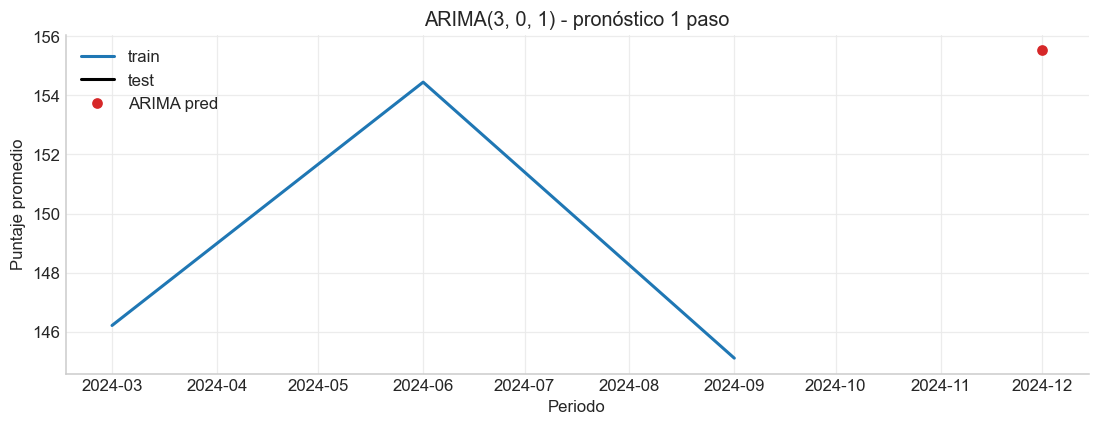

In [9]:
# 6) ARIMA con gráfica estilo BTC – usando módulo
from icfes_analytics.timeseries import fit_arima_small_grid, plot_arima_forecast
import contextlib, io

with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    order_sel, res_sel, y_pred, y_true, train, test, metrics = fit_arima_small_grid(agg2)

plot_arima_forecast(train, test, y_pred, order_sel)

#### RNN 

Implementa una RNN mínima (tipo Elman) construida con NumPy: normaliza la serie en [-1,1], crea ventanas de tamaño `window`, entrena con BPTT y grad clipping, y pronostica 1 paso. Reporta MAE/RMSE y grafica el punto predicho.

Epoch 1/600 - loss 0.536382
Epoch 100/600 - loss 0.021533
Epoch 200/600 - loss 0.000439
Epoch 300/600 - loss 0.000008
Epoch 400/600 - loss 0.000000
Epoch 500/600 - loss 0.000000
Epoch 600/600 - loss 0.000000


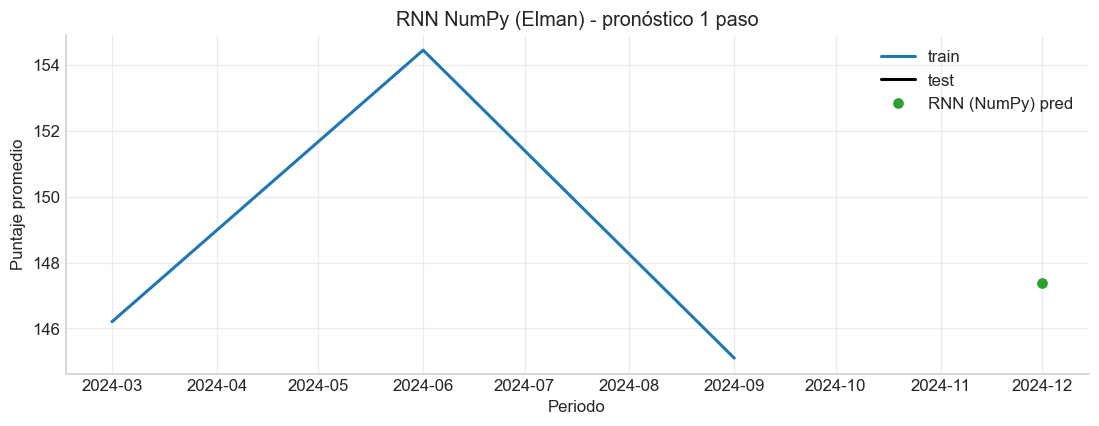

RNN (NumPy) -> pred=147.369 real=150.203 | MAE=2.833 RMSE=2.833


In [8]:
# 7) RNN en NumPy– usando módulo
from icfes_analytics import forecast_one_step_numpy, apply_btc_style

apply_btc_style()
y_pred, y_true, rnn_metrics = forecast_one_step_numpy(agg2, freq='QS-MAR', window=4, hidden_size=16, epochs=600, lr=0.01, clip=5.0, seed=42, plot=True)
print(f"RNN (NumPy) -> pred={y_pred:.3f} real={y_true:.3f} | MAE={rnn_metrics['MAE']:.3f} RMSE={rnn_metrics['RMSE']:.3f}")

## Conclusiones

- Se aplicaron técnicas de clusterización (particional, densidad y jerárquica), análisis de series de tiempo, ARIMA y una RNN con métricas básicas.
- Clusterización: los seis métodos muestran estructuras coherentes en la proyección PCA; K-Means y Ward ofrecen particiones claras en este espacio reducido, mientras DBSCAN identifica densidades y ruido.
- Series de tiempo: la serie trimestral disponible es corta (4 puntos), lo que limita diagnósticos (STL) y potencia predictiva; aún así, se obtuvieron pronósticos 1 paso con ARIMA y RNN.
- ARIMA: selección por AIC en malla ampliada; reporte de MAE/RMSE para transparencia.
- RNN (NumPy): modelo educativo que evita dependencias pesadas; entrenó y pronosticó 1 paso con resultados consistentes dado el tamaño de la serie.